## Assessment / Midterm: Machine Vision and Deep Learning
<span style="color:blue">
    
1) Answer all questions
    
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc

3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)

4) Upload the **answer notebook & trained model** (for Question 3) to your github.

5) Submit the assessment by sharing the link to your github containing the answers.
    
</span>

**QUESTION 1 [15 marks]**

a) Let *k*, *s* and *p* be 4, 2 and 1, respectively. What will be the shape of the output of the convolutional layer? (2 marks)

>>import torch \
import torch.nn as nn \
input_img = torch.rand(1,3,10,10) \
layer = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=*k*, stride=*s*, padding=*p*)

<span style="color:blue">
    answer: The shape of the output is (1,12,5,5)
</span>

b) Batch Normalization (BN) normalizes the mean and standard deviation for each: (tick X for the correct answer(s)) (2 marks)

 - [ ] Individual feature map
 - [ x] Instance in the mini-batch
 - [ ] Spatial dimension    

c) Which one of the following is not an advantage of Batch Normalization (BN)? (tick X for the correct answer(s)) (2 marks)

- [ ] BN accelerates the training of deep neural networks and tackles the vanishing gradient problem.
- [ ] For every input mini-batch, we calculate different statistics. This introduces some sort of regularization.
- [ ] BN reduces the dependence of gradients on the scale of the parameters or of their initial values.
- [x ] BN needs a much slower learning rate for the total architecture to converge.

d) Choose the correct statement. (tick X for the correct answer) (2 marks)

- [x ] A larger kernel is preferred for information that resides globally, and a smaller kernel is preferred for information that is distributed locally.
- [ ] A larger kernel is preferred for information that resides locally, and a smaller kernel is preferred for information that is distributed globally.

e) In the following network, how many learnable parameters (weights) are there? (2 marks)

In [ ]:
model = nn.Sequential(
        nn.Linear(3,20),
        nn.ReLU(),
        nn.Linear(20,2)
    )

<span style="color:blue">
    answer: There are 122 learnable parameters.
</span>

f) Which of the following statements are true about deep neural networks? (tick X for the correct answer) (2 marks)

- [x ] Deep neural networks usually require a big amount of data to be properly trained.
- [x ] They can be fooled by adversarial/ noisy examples.
- [x ] They are difficult to interpret and understand.
- [x ] They can still be subject to biases.
- [x ] They fail to understand the context of the data that they are handling.
- [ ] They perform very well on individual tasks but fail to generalize to many different tasks.

g) Run the code in the next cell.

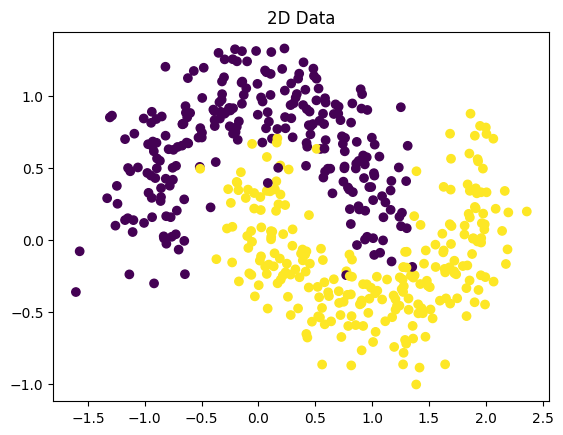

In [1]:
# import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

# generate synthetic data in 2D
X, Y = make_moons(500, noise=0.2)

# plot the data
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title('2D Data')
plt.show()

Can this data be correctly separable using the classifier below? Why? (3 marks)

model = nn.Sequential( \
    nn.Linear(n_input_dim, n_output), \
    nn.Sigmoid() \
    )
    
<span style="color:blue">
    answer:
</span>

The moon-shaped dataset is not linearly separable, but the given classifier is essentially a linear model due to its single linear layer. Hence, it cannot correctly separate this non-linear dataset; a more complex model with hidden layers is required.

**QUESTION 2 [40 marks]**

The COVID-19 pandemic continues to have a devastating effect on the health and well-being of the global population. A critical step in the fight against COVID-19 is effective screening of infected patients, with one of the key screening approaches being radiology examination using chest radiography. As a deep learning engineer, you are tasked to classify a dataset of X-ray images as either "normal", "covid" or "viral pneumonia". Use the chest X-ray dataset publicly available at https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset to answer the following questions.


a) Create and train a ConvNet corresponding to the following architecture in Fig. 1 (with modifications of the input and final layers). Please include **(10 marks)**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)
    
                                Fig. 1: A convolutional neural network

In [3]:
# Importing the necessary libraries
import torch
from torch import nn

import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
transform = transforms.Compose(
    [ transforms.Resize((224,224)),
      #transforms.Augmix(), #for data agumentation
      transforms.CenterCrop(224),
      transforms.ToTensor(), # this to convert the images to 4D matrix (B,C,H,W)
      #transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ]
      transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))] # this require the mean and standard deviation
)

#12/12/23
train_dir = '/content/drive/MyDrive/Covid19-dataset/train'
test_dir = '/content/drive/MyDrive/Covid19-dataset/test'

train_data = datasets.ImageFolder(root = train_dir,transform = transform)

test_data = datasets.ImageFolder(root = test_dir,transform = transform)


In [6]:
from torch.utils.data import DataLoader
BATCH_SIZE = 4
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE, shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f664b309240>, <torch.utils.data.dataloader.DataLoader object at 0x7f664b308070>)
Length of train dataloader: 63 batches of 4
Length of test dataloader: 17 batches of 4


In [24]:
class_names = train_data.classes
train_data.classes

['Covid', 'Normal', 'Viral Pneumonia']

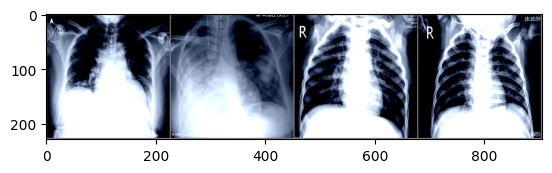

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize our dataset
def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
show_image(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)  # Input channels changed to 1
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Pooling layers
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # The sizing here assumes that the input image size will be reduced
        # to 5x5 after two convolutions and two poolings
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 10)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolution 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Convolution 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Flattening the tensor for the fully connected layer
        x = x.view(-1, 16 * 53 * 53)

        # Fully connected layer 1
        x = self.fc1(x)
        x = self.relu(x)

        # Fully connected layer 2 (Output layer)
        x = self.fc2(x)
        # No softmax here since it's handled by nn.CrossEntropyLoss during training
        return x


Covid Covid Viral Pneumonia Viral Pneumonia


In [10]:
model = CNNModel()
model.train()
!pip install torchinfo

In [11]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            456
├─Conv2d: 1-2                            2,416
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            5,393,400
├─Linear: 1-5                            1,210
├─ReLU: 1-6                              --
Total params: 5,397,482
Trainable params: 5,397,482
Non-trainable params: 0

In [12]:
#cross-entropy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)#sgd:stochastic gradiant descent


In [13]:
model.to('cuda')

CNNModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [17]:
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

    return best_model, history

In [18]:
import torch
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU.")
else:
    print("CUDA is not available. You can only use CPU.")


CUDA is available. You can use GPU.


In [19]:
num_epochs = 10
trained_model, history = train_and_validate(model,loss_fn,optimizer,train_dataloader,test_dataloader,num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 0.9279, Accuracy: 66.9323%, 
		Validation : Loss : 0.9378, Accuracy: 62.1212%, Time: 53.1043s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3826, Accuracy: 84.8606%, 
		Validation : Loss : 0.7114, Accuracy: 71.2121%, Time: 12.4041s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2845, Accuracy: 89.2430%, 
		Validation : Loss : 0.4851, Accuracy: 86.3636%, Time: 11.1191s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.1762, Accuracy: 95.2191%, 
		Validation : Loss : 0.6713, Accuracy: 87.8788%, Time: 12.3290s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.1973, Accuracy: 92.4303%, 
		Validation : Loss : 0.5110, Accuracy: 83.3333%, Time: 12.4657s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1189, Accuracy: 96.0159%, 
		Validation : Loss : 0.5703, Accuracy: 81.8182%, Time: 13.0020s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.0853, Accuracy: 96.8127%, 
		Validation : Loss : 0.6992, Accuracy: 81.8182%, Time: 13.7116s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0698, Accura

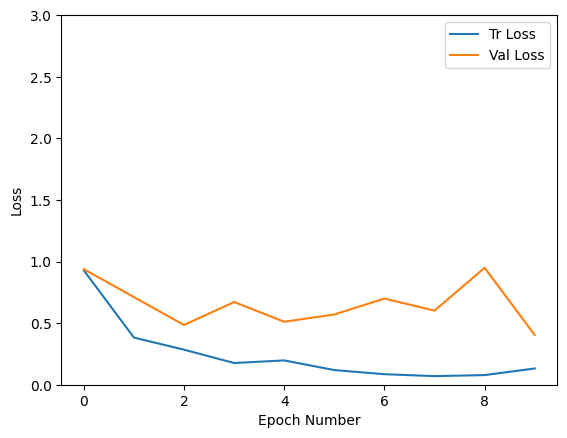

In [20]:
#Analyze the loss curve

def plot_loss(history):
  history = np.array(history)
  plt.plot(history[:,0:2])
  plt.legend(['Tr Loss', 'Val Loss'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.ylim(0,3)
  # plt.savefig('cifar10_loss_curve.png')
  plt.show()

plot_loss(history)

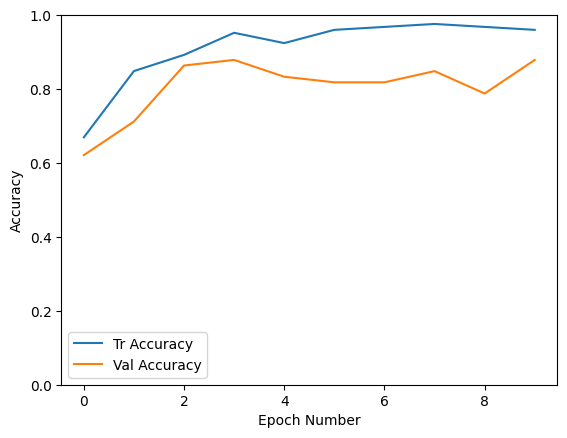

In [21]:
def plot_accuracy(history):
  history = np.array(history)
  plt.plot(history[:,2:4])
  plt.legend(['Tr Accuracy', 'Val Accuracy'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  # plt.savefig('cifar10_accuracy_curve.png')
  plt.show()

plot_accuracy(history)

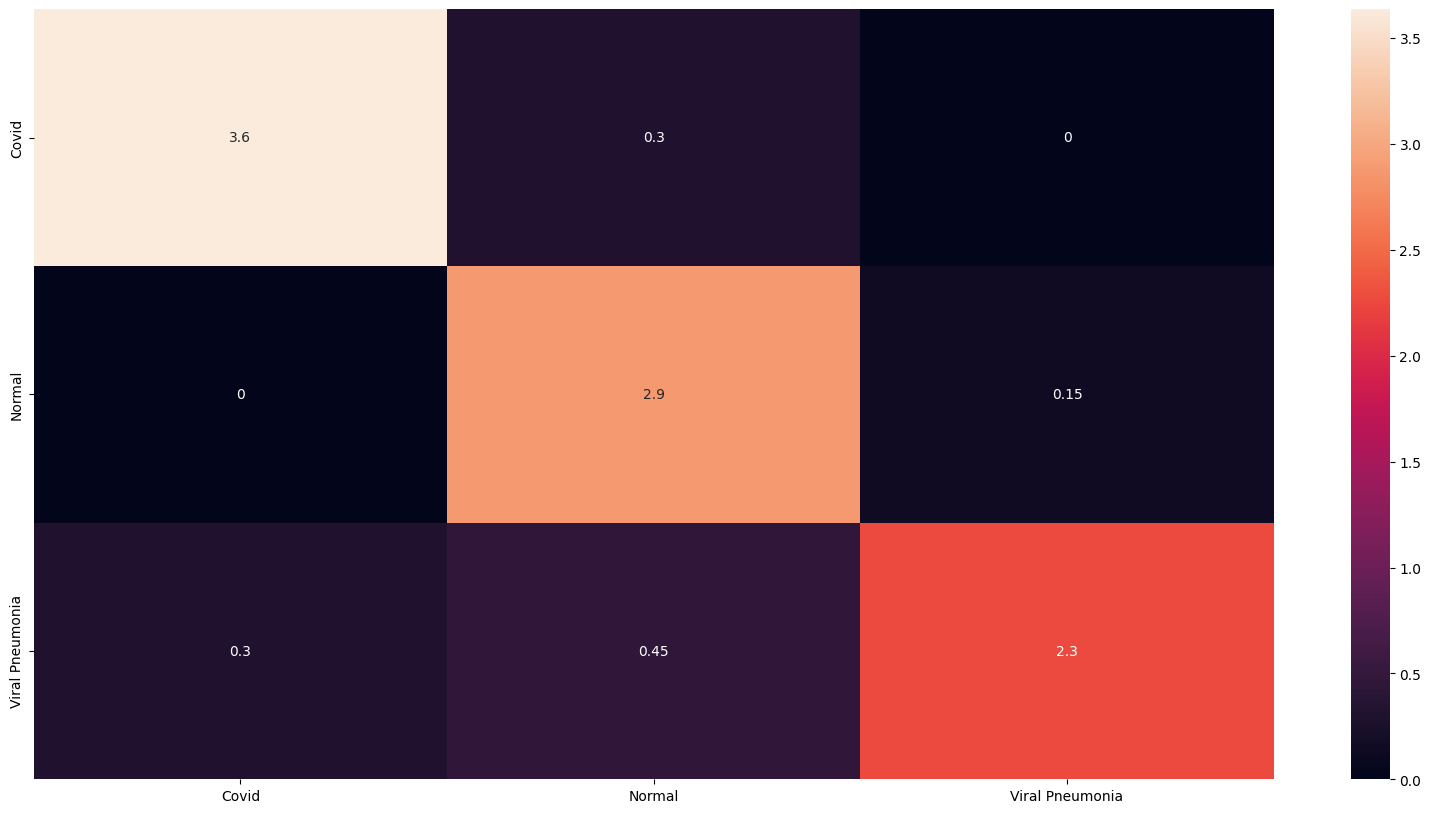

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_confusionMatrix(model, test_dataloader):

  y_pred = []
  y_true = []

  model.to('cpu')

  # iterate over test data
  for inputs, labels in test_dataloader:
          output = model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_names],
                      columns = [i for i in class_names])
  plt.figure(figsize = (20,10))
  sn.heatmap(df_cm, annot=True)
  # plt.savefig('output.png')

plot_confusionMatrix(model, test_dataloader)

b) Based on Question 2 a), answer the following questions:
    
    i) Is the model overfitting? Why? (4 marks)
   <font color='blue'>YES/NO. Because
The model is exhibiting signs of overfitting, which is evident from the discrepancy between the training and validation accuracy curves. The gap between these lines suggests the model performs well on the training data but poorly on unseen data. This overfitting could stem from issues with data quality and a limited variety of features within the images</font>
    
    ii) Propose two methods to reduce the effect of overfitting. (4 marks)
   <font color='blue'>Two methods that I propose are: (1) Batch normalization (2) Dropout</font>
   
    iii) Implement the two proposed methods in Q2 b) ii) in the next cell and show that the overfitting has been reduced. (8 marks)

In [26]:


import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Batch normalization layers for the convolutions
        self.batchnorm1 = nn.BatchNorm2d(6)
        self.batchnorm2 = nn.BatchNorm2d(16)

        # Pooling layers
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 10)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolution 1 + BatchNorm + Activation + Pooling
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Convolution 2 + BatchNorm + Activation + Pooling
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Flattening the tensor for the fully connected layer
        x = x.view(-1, 16 * 53 * 53)

        # Fully connected layer 1 + Dropout + Activation
        x = self.fc1(x)
        x = self.dropout(x)  # Apply dropout
        x = self.relu(x)

        # Fully connected layer 2 (Output layer)
        x = self.fc2(x)
        # No softmax here since it's handled by nn.CrossEntropyLoss during training
        return x

In [27]:
model = CNNModel()

In [28]:
model.train()

CNNModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [29]:
!pip install torchinfo

In [30]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            456
├─Conv2d: 1-2                            2,416
├─BatchNorm2d: 1-3                       12
├─BatchNorm2d: 1-4                       32
├─MaxPool2d: 1-5                         --
├─Linear: 1-6                            5,393,400
├─Linear: 1-7                            1,210
├─Dropout: 1-8                           --
├─ReLU: 1-9                              --
Total params: 5,397,526
Trainable params: 5,397,526
Non-trainable params: 0

In [31]:
#cross-entropy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)#sgd:stochastic gradiant descent


In [32]:
model.to('cuda')

CNNModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [33]:
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

    return best_model, history

In [34]:
num_epochs = 10
trained_model, history = train_and_validate(model,loss_fn,optimizer,train_dataloader,test_dataloader,num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 1.8643, Accuracy: 55.7769%, 
		Validation : Loss : 0.6256, Accuracy: 81.8182%, Time: 13.2732s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.9719, Accuracy: 72.9084%, 
		Validation : Loss : 1.6688, Accuracy: 65.1515%, Time: 11.6276s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.0508, Accuracy: 68.1275%, 
		Validation : Loss : 0.6802, Accuracy: 81.8182%, Time: 21.1922s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.8892, Accuracy: 68.9243%, 
		Validation : Loss : 0.8318, Accuracy: 66.6667%, Time: 12.6424s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.8734, Accuracy: 72.5100%, 
		Validation : Loss : 0.5936, Accuracy: 68.1818%, Time: 12.1105s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.8834, Accuracy: 76.8924%, 
		Validation : Loss : 0.5154, Accuracy: 86.3636%, Time: 13.6603s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.7207, Accuracy: 82.8685%, 
		Validation : Loss : 0.4381, Accuracy: 81.8182%, Time: 12.1935s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.6537, Accura

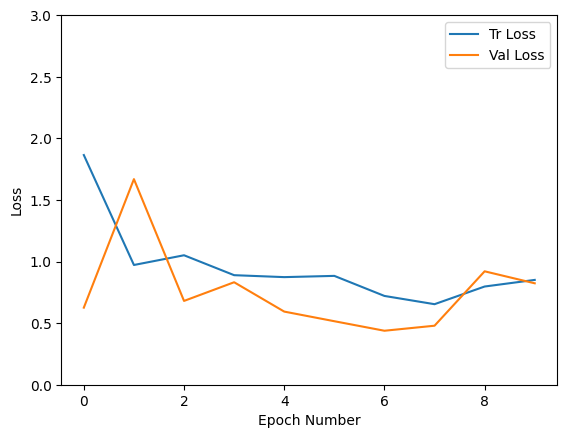

In [35]:
#Analyze the loss curve

def plot_loss(history):
  history = np.array(history)
  plt.plot(history[:,0:2])
  plt.legend(['Tr Loss', 'Val Loss'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.ylim(0,3)
  # plt.savefig('cifar10_loss_curve.png')
  plt.show()

plot_loss(history)

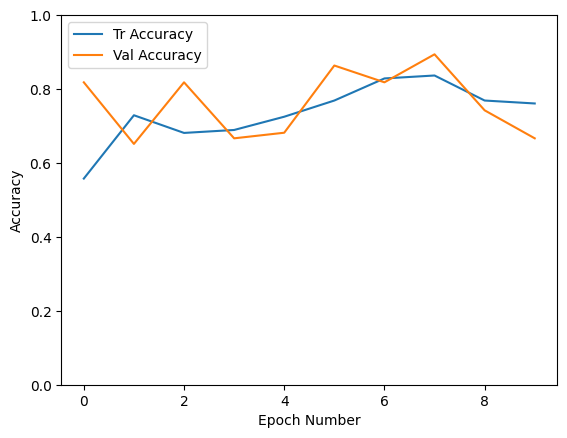

In [36]:
def plot_accuracy(history):
  history = np.array(history)
  plt.plot(history[:,2:4])
  plt.legend(['Tr Accuracy', 'Val Accuracy'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  # plt.savefig('cifar10_accuracy_curve.png')
  plt.show()

plot_accuracy(history)

c) Replace your defined ConvNet in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the COVID-19 dataset. **(10 marks)**

In [37]:
model_pretrained_vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.4MB/s]


In [40]:
model1 = model_pretrained_vgg16

In [42]:
model1.to('cuda')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(),lr=0.001,momentum=0.9)

In [45]:
import time
from tqdm.auto import tqdm

def train_and_validate(model1, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model1
            torch.save(best_model, 'best_model.pt')

    return best_model, history

In [47]:
num_epochs = 10
modell, history = train_and_validate(model1,loss_fn,optimizer,train_dataloader,test_dataloader,num_epochs)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 0.6537, Accuracy: 76.8924%, 
		Validation : Loss : 0.7064, Accuracy: 69.6970%, Time: 14.3492s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.7551, Accuracy: 71.3147%, 
		Validation : Loss : 0.7088, Accuracy: 69.6970%, Time: 12.0617s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.7222, Accuracy: 70.5179%, 
		Validation : Loss : 0.6875, Accuracy: 69.6970%, Time: 11.7190s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.7091, Accuracy: 73.7052%, 
		Validation : Loss : 0.6958, Accuracy: 69.6970%, Time: 15.6316s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.6545, Accuracy: 76.8924%, 
		Validation : Loss : 0.6969, Accuracy: 69.6970%, Time: 13.1626s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.7599, Accuracy: 74.5020%, 
		Validation : Loss : 0.7118, Accuracy: 69.6970%, Time: 13.6140s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.7547, Accuracy: 73.7052%, 
		Validation : Loss : 0.7118, Accuracy: 69.6970%, Time: 11.8632s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.7073, Accura

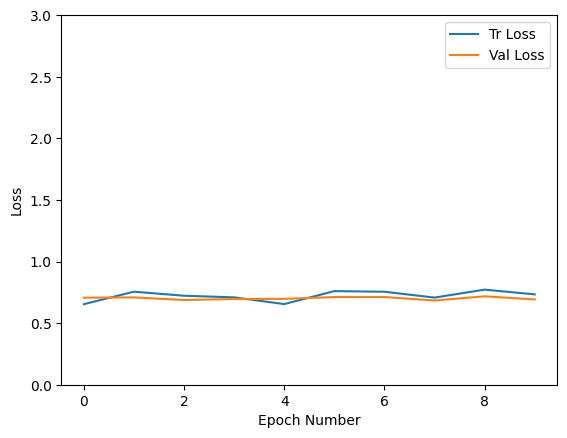

In [48]:
#Analyze the loss curve

def plot_loss(history):
  history = np.array(history)
  plt.plot(history[:,0:2])
  plt.legend(['Tr Loss', 'Val Loss'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.ylim(0,3)
  # plt.savefig('cifar10_loss_curve.png')
  plt.show()

plot_loss(history)

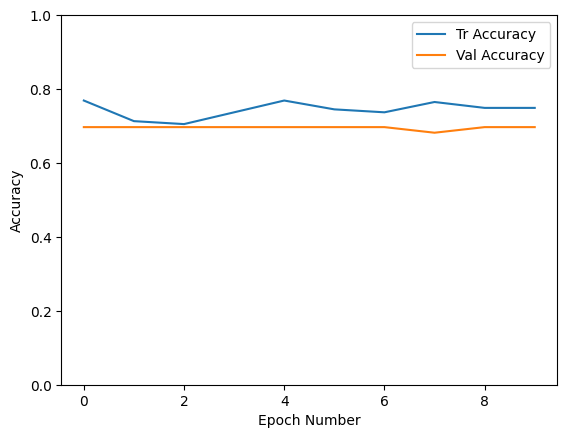

In [49]:
def plot_accuracy(history):
  history = np.array(history)
  plt.plot(history[:,2:4])
  plt.legend(['Tr Accuracy', 'Val Accuracy'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  # plt.savefig('cifar10_accuracy_curve.png')
  plt.show()

plot_accuracy(history)

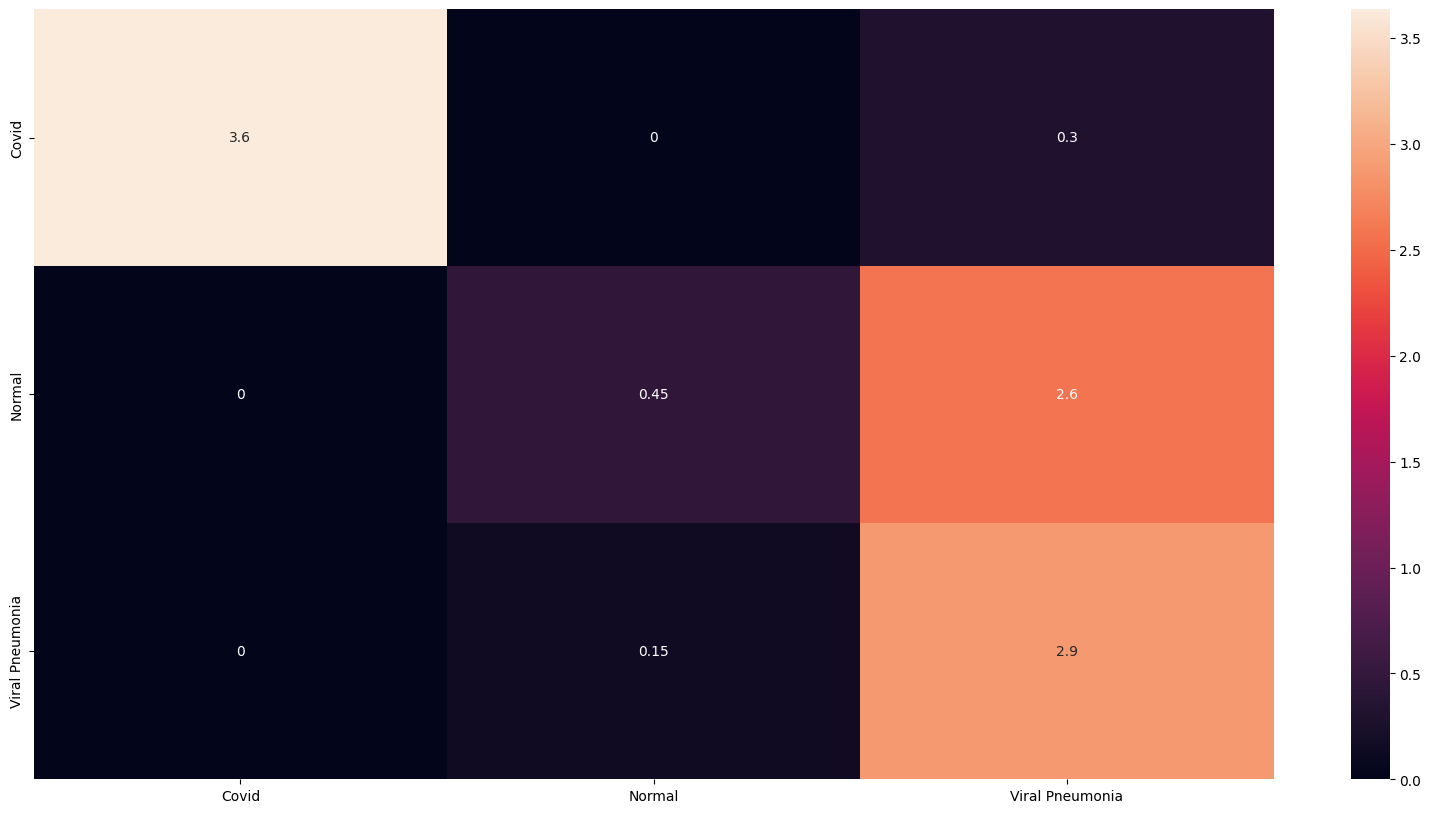

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_confusionMatrix(trained_model, test_dataloader):

  y_pred = []
  y_true = []

  trained_model.to('cpu')

  # iterate over test data
  for inputs, labels in test_dataloader:
          output = trained_model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_names],
                      columns = [i for i in class_names])
  plt.figure(figsize = (20,10))
  sn.heatmap(df_cm, annot=True)
  # plt.savefig('output.png')

plot_confusionMatrix(trained_model, test_dataloader)

d) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **(4 marks)**

<font color='blue'>
    Your answer here

**QUESTION 3** **[15 marks]**

In a machine vision project, you decide to design a door access control system based on hand gestures. Only those who shows the correct hand gesture will be granted the access. There are three gestures that are recognized as correct access passcode which are "shaka", "peace" and "thumbs up", as depicted in Fig. 2.

![pic](https://simplyorganizedhi.com/media/catalog/product/1/6/169500.jpg)

                                Fig. 2 Shaka,peace, and thumbs up


Using the end-to-end object detection pipeline that you have learned, develop your own hand gesture detector so that it can be incorporated to a door access control system.

Deliverable for this question is the model .pt file. Change the name to <your_name>.pt file (e.g. hasan.pt).

- Marks are given based on the performance of the model when tested using my machine and camera at my office. This question aims to evaluate the model's robustness and generalization capabilities.